In [1]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))  # adjust '..' as needed
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
# -------------------------------
# 1. Imports
# -------------------------------
import evaluate # Hugging Face splits metrics into a separate package
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import plotly.express as px
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset

In [3]:
# -------------------------------
# 2. Load CSVs
# -------------------------------
train_df = pd.read_csv("../data/train_data.csv").dropna()
val_df   = pd.read_csv("../data/val_data.csv").dropna()
test_df  = pd.read_csv("../data/test_data.csv").dropna()

# Get all unique labels from training set
label_names = sorted(train_df['label'].unique())  # e.g. ['FAKE','REAL','NEUTRAL','OTHER']
label2id = {name: i for i, name in enumerate(label_names)}

# Apply mapping to all splits
for df in [train_df, val_df, test_df]:
    df['label'] = df['label'].map(label2id)

X_train = train_df['text']
y_train = train_df['label'].values

X_val = val_df['text']
y_val = val_df['label'].values

X_test = test_df['text']
y_test = test_df['label'].values


# For Hugging Face dataset format
from datasets import Dataset

train_dataset = Dataset.from_dict({'text': X_train, 'label': y_train})
val_dataset   = Dataset.from_dict({'text': X_val, 'label': y_val})
test_dataset  = Dataset.from_dict({'text': X_test, 'label': y_test})

In [4]:
# -------------------------------
# 3. Quick test: Pretrained pipeline (no training)
# -------------------------------
from transformers import pipeline
classifier = pipeline("text-classification", model="distilbert-base-uncased", device=0)  # device=0 for GPU

sample_texts = ["The climate is changing faster than expected.", "Some claims about climate are fake."]
print("Quick predictions:", classifier(sample_texts))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use mps:0


Quick predictions: [{'label': 'LABEL_1', 'score': 0.5011120438575745}, {'label': 'LABEL_0', 'score': 0.5146113634109497}]


In [5]:
# -------------------------------
# 4. Fine-tuning a pretrained model
# -------------------------------
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model     = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(np.unique(y_train)))

import numpy as np
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
from transformers import Trainer

# Compute class weights from training data
class_counts = np.bincount(y_train)  # count per numeric label
total = sum(class_counts)
weights = [total/c for c in class_counts]  # inverse frequency weighting
weights = torch.tensor(weights, dtype=torch.float)

import plotly.graph_objects as go

# Map back to label names
id2label = {i: name for name, i in label2id.items()}

freqs = class_counts.tolist()
wts   = weights.tolist()

fig = go.Figure(data=[
    go.Bar(name="Class Frequency", x=[id2label[i] for i in range(len(freqs))], y=freqs),
    go.Bar(name="Class Weight",    x=[id2label[i] for i in range(len(wts))], y=wts)
])

fig.update_layout(
    barmode='group',
    title="Class Frequencies vs. Weights",
    xaxis_title="Label",
    yaxis_title="Value",
    template="plotly_white"
)

fig.show()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:

# Tokenization
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True, max_length=128)

train_dataset = train_dataset.map(tokenize, batched=True)
val_dataset   = val_dataset.map(tokenize, batched=True)
test_dataset  = test_dataset.map(tokenize, batched=True)

train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

# -------------------------------
# 5. Train / fine-tune
# -------------------------------
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=10,
    learning_rate=1e-5,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none"   # <-- disables wandb, tensorboard, etc.
)

Map:   0%|          | 0/1388 [00:00<?, ? examples/s]

Map:   0%|          | 0/297 [00:00<?, ? examples/s]

Map:   0%|          | 0/298 [00:00<?, ? examples/s]

In [ ]:
from src.utils import compute_metrics
from src.models import WeightedTrainer
import torch.nn as nn

#trainer = Trainer(
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

/Users/dianamendez/environmental-misinformation/src/utils.py:134: FutureWarning:

`tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.

/Users/dianamendez/environmental-misinformation/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning:

'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.



Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.553300,0.560543,0.740741,0.548697,0.740741,0.630418
2,0.540300,0.564435,0.740741,0.548697,0.740741,0.630418
3,0.560400,0.563973,0.740741,0.548697,0.740741,0.630418
4,0.475100,0.563009,0.740741,0.548697,0.740741,0.630418
5,0.493600,0.566637,0.740741,0.548697,0.740741,0.630418


/Users/dianamendez/environmental-misinformation/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/dianamendez/environmental-misinformation/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning:

'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.

/Users/dianamendez/environmental-misinformation/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/dianamendez/environmental-misinformation/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning:

'pin_memory' argument is set as true but not support

TrainOutput(global_step=435, training_loss=0.5299685993413815, metrics={'train_runtime': 64.4708, 'train_samples_per_second': 107.646, 'train_steps_per_second': 6.747, 'total_flos': 166986539922960.0, 'train_loss': 0.5299685993413815, 'epoch': 5.0})

In [8]:
# -------------------------------
# 6. Evaluation on test set
# -------------------------------
preds_output = trainer.predict(test_dataset)
y_pred = np.argmax(preds_output.predictions, axis=1)

# Bring back original labels
id2label = {v:k for k,v in label2id.items()}
y_test_labels = [id2label[i] for i in y_test]
y_pred_labels = [id2label[i] for i in y_pred]

print(classification_report(y_test_labels, y_pred_labels, zero_division=0))

/Users/dianamendez/environmental-misinformation/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning:

'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.



/Users/dianamendez/environmental-misinformation/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



              precision    recall  f1-score   support

LIKELY_FALSE       0.00      0.00      0.00        78
 LIKELY_TRUE       0.74      1.00      0.85       220

    accuracy                           0.74       298
   macro avg       0.37      0.50      0.42       298
weighted avg       0.55      0.74      0.63       298



In [9]:
# -------------------------------
# 7. Confusion Matrix
# -------------------------------
from src.viz import *
cm = confusion_matrix(y_test_labels, y_pred_labels)
cm_df = pd.DataFrame(cm, index=np.unique(y_test_labels), columns=np.unique(y_test_labels))

fig = px.imshow(cm_df,
                text_auto=True,
                labels=dict(x="Predicted", y="Actual", color="Count"),
                color_continuous_scale="Blues",
                title="Confusion Matrix")
fig.show()

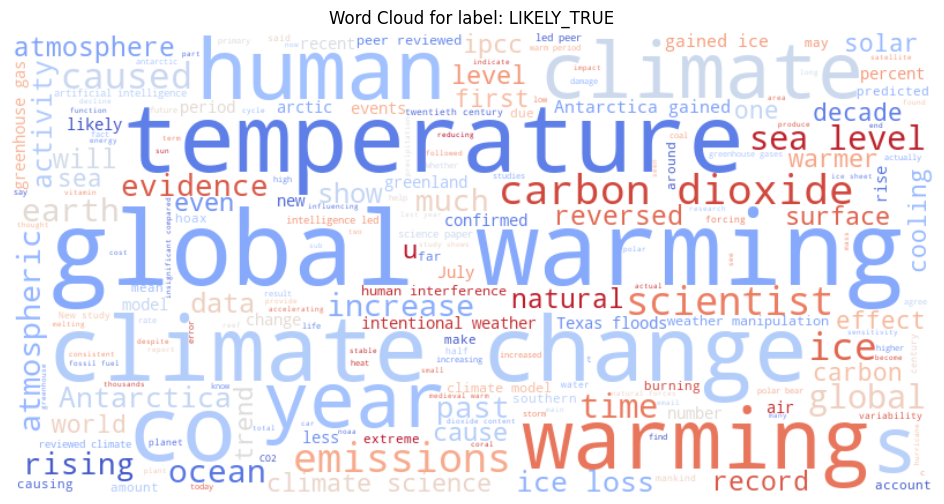

In [10]:
# -------------------------------
# 8. Word Clouds for each label
# -------------------------------
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# First, create a DataFrame with text + predicted label
test_texts = test_df["text"].tolist()
pred_labels = y_pred_labels

df_pred = pd.DataFrame({
    "text": test_texts,
    "pred": pred_labels
})

label_names = np.unique(y_pred_labels)

# Generate a word cloud per label
for lbl in label_names:
    texts = " ".join(df_pred[df_pred["pred"]==lbl]["text"])

    # Create the word cloud
    wc = WordCloud(width=800, height=400, background_color="white", colormap="coolwarm").generate(texts)

    plt.figure(figsize=(12,6))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud for label: {lbl}")
    plt.show()

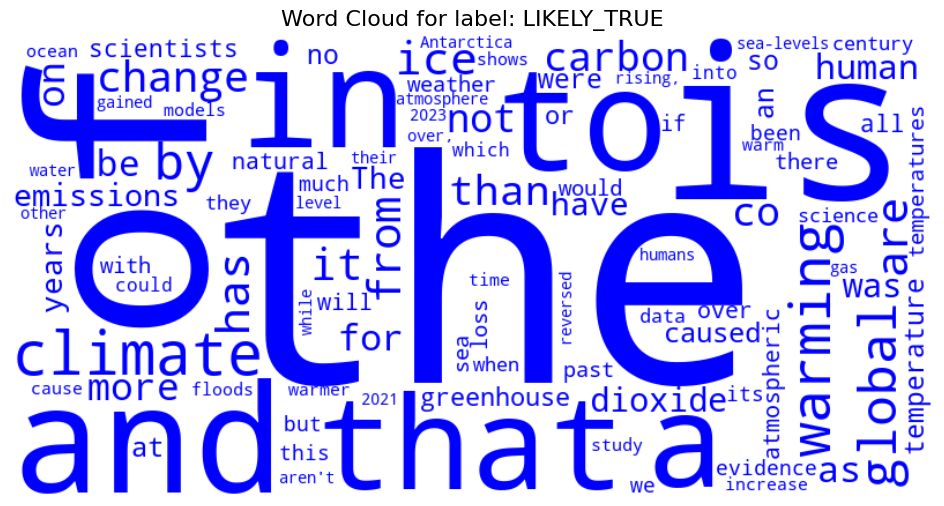

In [11]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

df_pred = pd.DataFrame({
    "text": test_texts,
    "pred": y_pred_labels
})

# Colors per label
label_colors = {
    "LIKELY_TRUE": "blue",
    "LIKELY_FALSE": "red"
    # "SUPPORTS": "seagreen",
    # "REFUTES": "crimson",
    # "NEUTRAL": "gray",
    # "DISPUTED": "orange"
}

for lbl in np.unique(y_pred_labels):
    texts = " ".join(df_pred[df_pred["pred"]==lbl]["text"])
    if not texts.strip():
        print(f"No predictions for label {lbl}, skipping word cloud.")
        continue

    word_freq = Counter(texts.split())

    wc = WordCloud(
        width=800,
        height=400,
        background_color="white",
        max_words=100,
        color_func=lambda *args, **kwargs: label_colors[lbl]  # pass label directly here
    ).generate_from_frequencies(word_freq)

    plt.figure(figsize=(12,6))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud for label: {lbl}", fontsize=16)
    plt.show()